# Time Series LSTM model 

- Differencing 으로 Trend 제거  
- train / test split
- feature scaling  
- supervised learning dataset 생성  
- inverse transform  
- 예측한 difference 를 원래의 시계열로 환원  
- 시각화

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
import tensorflow as tf

- dataset 의 Month column 을 datetime 으로 변환

date_parser : 문자열 열의 시퀀스를 datetime 인스턴스의 배열로 변환하는 데 사용할 함수 지정

In [2]:
df = pd.read_csv("datasets/shampoo-sales.csv")
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [3]:
# 'Month' 열의 각 값을 변환하여 앞에 '190'을 추가합니다. 
df['Month'] = df['Month'].map(lambda x: '190'+x)

# 변환된 'Month' 열을 날짜 형식으로 변경합니다. 'format' 매개변수를 사용하여 입력 포맷을 '%Y-%m'으로 지정합니다.
# 이로써 'Month' 열은 문자열 형태에서 pandas의 datetime 객체로 변환되어 날짜와 시간 관련 연산이 가능해집니다.
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

In [4]:
df.set_index('Month', inplace=True)
df.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


<Axes: xlabel='Month'>

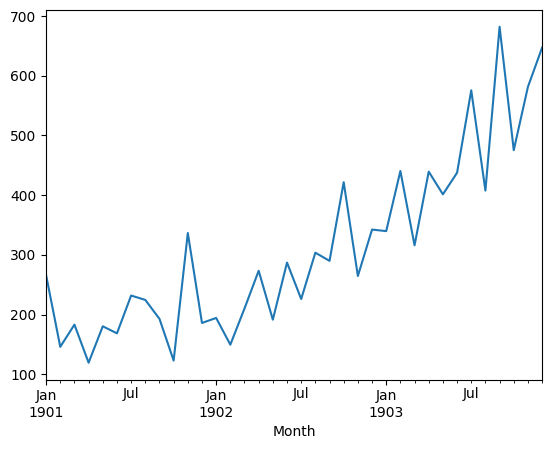

In [5]:
df['Sales'].plot()

- trend 를 제거하여 stationary 한 시계열 생성. model 은 difference를 학습.

In [6]:
differenced = df.diff().dropna()
differenced.head()

,Sales
Month,
1901-02-01,-120.1
1901-03-01,37.2
1901-04-01,-63.8
1901-05-01,61.0
1901-06-01,-11.8


In [7]:
differenced.shape

(35, 1)

### train/test split
- train : 23 개월
- test : 12 개월

In [8]:
train = np.array(differenced[:-12]).reshape(-1, 1)
test  = np.array(differenced[-12:]).reshape(-1, 1)
train.shape, test.shape

((23, 1), (12, 1))

### feature scaling

In [9]:
sc = MinMaxScaler()
train_scaled = sc.fit_transform(train)
test_scaled = sc.transform(test)

## Supervised Learning dataset 작성

In [10]:
def windowed_dataset(series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    
    # 데이터셋을 윈도우로 나눔. 각 윈도우는 window_size+1의 크기를 가짐.
    # shift=1로 설정하여 각 윈도우가 한 스텝씩 이동하게 함.
    # drop_remainder=True로 설정하여 마지막 부분의 데이터가 window_size+1보다 작으면 제외함.
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    
    # flat_map을 사용하여 각 윈도우를 단일 배치로 편리하게 변환.
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    
    # 각 윈도우에서 마지막 값을 레이블로 사용하고 나머지를 입력 데이터로 사용.
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    
    # 지정된 배치 크기로 데이터셋을 배치 처리하고, prefetch(1)로 성능 최적화.
    # prefetch(1)은 학습하는 동안 다음 데이터를 미리 준비함으로써 대기 시간을 줄임.
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [11]:
window_size = 1
batch_size = 6

In [12]:
train_ds = windowed_dataset(train_scaled, window_size, batch_size)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [13]:
test_ds = windowed_dataset(test_scaled, window_size, len(test_scaled))
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [14]:
for x, y in train_ds:
    print(x.numpy().shape)
    print(y.numpy().shape)
    break

(6, 1, 1)
(6, 1)


In [15]:
for x, y in test_ds:
    print(x.numpy().shape)
    print(y.numpy().shape)
    break

(11, 1, 1)
(11, 1)


- model 생성

In [16]:
model = Sequential([
    tf.keras.layers.LSTM(20, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(train_ds, epochs=500)

Epoch 1/500
4/4 [==============================] - 1s 13ms/step - loss: 0.2443
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2351
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2263
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2176
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2090
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2007
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.1927
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 0.1849
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.1773
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 0.1700
Epoch 11/500
4/4 [==============================] - 0s 2ms/step - loss: 0.1630
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 0.1562
Epoch 13/500
4/4 [==============================] - 0s 1ms/s

In [17]:
y_hat = model.predict(test_ds)
y_hat.shape

1/1 [==============================] - 0s 280ms/step


(11, 1)

- denormalize

In [18]:
# 예측된 값을 원래의 스케일로 변환
y_hat = sc.inverse_transform(y_hat)
y_hat

array([[  23.058035 ],
       [ -59.99852  ],
       [  82.49877  ],
       [ -81.72211  ],
       [  44.80563  ],
       [  -4.7834697],
       [ -96.35905  ],
       [  93.283775 ],
       [-247.75624  ],
       [  98.61019  ],
       [ -64.9708   ]], dtype=float32)

- model 은 difference를 예측하도록 학습하였으므로, 원래의 시계열로 변환 
- 당일 value = 전일 value + difference(y_hat) 이므로,  
  `prediction = series[-len(yhat)-1:-1] + yhat`  
  `true_vales = series[-len(yhat):]`

- 모델은 데이터의 변화량(차이)을 예측하도록 훈련되었습니다. 따라서, 예측 결과를 원래 시계열 데이터의 형태로 되돌려야 합니다.
- 하루의 값은 전날의 값에 그 날의 변화량(예측값 `yhat`)을 더한 것과 같습니다. 이를 통해 예측 시퀀스를 다음과 같이 계산할 수 있습니다:
  - `prediction = series[-len(yhat)-1:-1] + yhat`: 이 코드는 예측값 `yhat`을 사용하여 원래 시계열의 마지막 부분에 변화량을 더해 새로운 예측값을 생성합니다. 여기서 `series[-len(yhat)-1:-1]`는 예측 기간 바로 이전의 실제 데이터 포인트를 나타냅니다.
  - `true_values = series[-len(yhat):]`: 이 코드는 예측 기간 동안의 실제 값을 가져옵니다. 이 값들은 모델의 예측 성능을 평가하는 데 사용됩니다.

In [19]:
series = df.values
series.shape

(36, 1)

In [20]:
# series에서 예측값 y_hat의 길이보다 하나 더 긴 부분을 선택하고, 예측값을 더하여 예측 시퀀스 생성
# 이는 과거 데이터에 예측값을 더해 미래 값을 예측하는 방식입니다.
prediction = series[-len(y_hat)-1:-1]  + y_hat
prediction

array([[362.7580349 ],
       [380.4014801 ],
       [398.39877167],
       [357.57789307],
       [446.10562973],
       [432.61653032],
       [479.14095306],
       [500.88377533],
       [434.24375916],
       [573.91019135],
       [516.32919769]])

In [21]:
# 실제 값과 비교하기 위해, series에서 y_hat의 길이만큼의 최신 데이터를 선택합니다.
true_values = series[-len(y_hat):]
true_values

array([[440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

In [22]:
for i in range(len(prediction)):
    print(f'예측값 = {prediction[i][0]:.2f}, 실제값 = {true_values[i][0]:.2f}')

예측값 = 362.76, 실제값 = 440.40
예측값 = 380.40, 실제값 = 315.90
예측값 = 398.40, 실제값 = 439.30
예측값 = 357.58, 실제값 = 401.30
예측값 = 446.11, 실제값 = 437.40
예측값 = 432.62, 실제값 = 575.50
예측값 = 479.14, 실제값 = 407.60
예측값 = 500.88, 실제값 = 682.00
예측값 = 434.24, 실제값 = 475.30
예측값 = 573.91, 실제값 = 581.30
예측값 = 516.33, 실제값 = 646.90


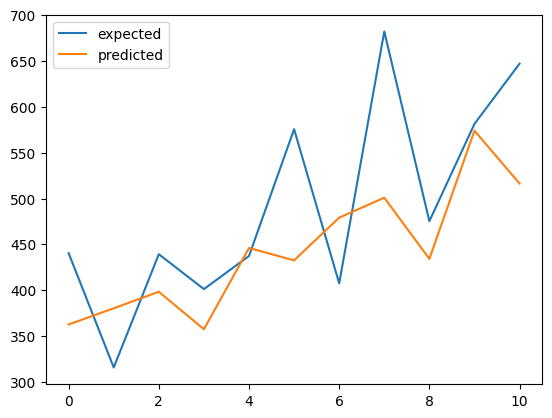

In [23]:
plt.plot(true_values, label='expected')
plt.plot(prediction, label='predicted')
plt.legend()